<a href="https://colab.research.google.com/github/vathsal14/first-demo/blob/main/pre_processing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.9 MB/s eta 0:00:00


In [4]:
import mne
import pandas as pd
import numpy as np
eeg_data = pd.read_csv("data.csv")

In [10]:
eeg_data_cleaned = eeg_data.drop(columns=["Unnamed: 0"])


X = eeg_data_cleaned.drop(columns=["y"]).values
y = eeg_data_cleaned["y"].values


n_channels = X.shape[1]
sfreq = 250
ch_names = [f"Ch{i}" for i in range(1, n_channels + 1)]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")


raw = mne.io.RawArray(X.T, info)

Creating RawArray with float64 data, n_channels=178, n_times=3156
    Range : 0 ... 3155 =      0.000 ...    12.620 secs
Ready.


In [11]:
raw.filter(l_freq=1.0, h_freq=50.0)
raw.notch_filter(freqs=50.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


<RawArray | 178 x 3156 (12.6 s), ~4.5 MB, data loaded>

In [12]:
raw.set_eeg_reference("average")


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 178 x 3156 (12.6 s), ~4.5 MB, data loaded>

In [34]:
raw = mne.io.RawArray(X.T, info)

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing="ignore")

def clean_data(data):
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

raw.apply_function(clean_data, channel_wise=False)

print("Annotations in raw data:", raw.annotations)
raw.set_annotations(None)
raw.interpolate_bads(reset_bads=True)

raw.pick_types(eeg=True)

raw.filter(1., 40., fir_design='firwin')

raw.apply_function(clean_data, channel_wise=False)
print("Final check - NaN values:", np.isnan(raw.get_data()).any())
print("Final check - Inf values:", np.isinf(raw.get_data()).any())

ica = ICA(n_components=15, random_state=97, max_iter="auto")
try:
    ica.fit(raw)
    print("ICA fitting successful!")
    ica.plot_components()
    ica.exclude = [0, 1]  # Example exclusions
    raw_clean = ica.apply(raw.copy())
    print("ICA applied successfully.")
except ValueError as e:
    print("ICA failed with error:", e)


Creating RawArray with float64 data, n_channels=178, n_times=3156
    Range : 0 ... 3155 =      0.000 ...    12.620 secs
Ready.
Annotations in raw data: <Annotations | 0 segments>
Setting channel interpolation method to {'eeg': 'spline'}.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



<ipython-input-34-7e812fbc0551>:13: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Final check - NaN values: False
Final check - Inf values: False
Fitting ICA to data using 178 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


ICA failed with error: array must not contain infs or NaNs


/usr/local/lib/python3.10/dist-packages/mne/preprocessing/ica.py:885: RuntimeWarning: invalid value encountered in divide
  data /= self.pre_whitener_


In [31]:
n_times = len(raw.times)
dummy_events = np.array([[i, 0, 1] for i in range(0, n_times, sfreq * 2)])
event_id = {"Dummy Event": 1}
epochs = mne.Epochs(raw, events=dummy_events, event_id=event_id, tmin=0, tmax=2, baseline=None)

Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated


In [32]:
output_path = "preprocessed_eeg_data-raw.fif"
raw.save(output_path, overwrite=True)

Writing /content/preprocessed_eeg_data-raw.fif
Closing /content/preprocessed_eeg_data-raw.fif
[done]


In [33]:
epochs_output_path = "preprocessed_eeg_data-epochs.fif"
epochs.save(epochs_output_path, overwrite=True)

print(f"Preprocessed raw data saved to: {output_path}")
print(f"Preprocessed epochs data saved to: {epochs_output_path}")

Using data from preloaded Raw for 7 events and 501 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 501 original time points ...
Using data from preloaded Raw for 6 events and 501 original time points ...
Preprocessed raw data saved to: preprocessed_eeg_data-raw.fif
Preprocessed epochs data saved to: preprocessed_eeg_data-epochs.fif


<ipython-input-33-32a686a5c2b7>:2: RuntimeWarning: This filename (preprocessed_eeg_data-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(epochs_output_path, overwrite=True)


Opening raw data file preprocessed_eeg_data-raw.fif...
    Range : 0 ... 3155 =      0.000 ...    12.620 secs
Ready.
Reading 0 ... 3155  =      0.000 ...    12.620 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8, Ch9, Ch10, Ch11, Ch12, ...
 chs: 178 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 178
 projs: []
 sfreq: 250.0 Hz
>
Using matplotlib as 2D backend.


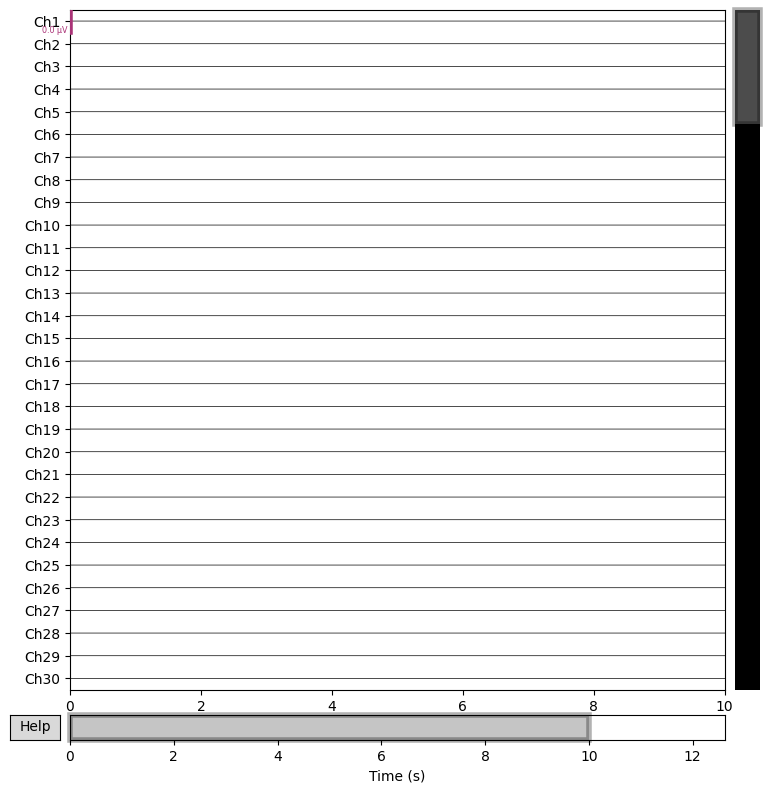

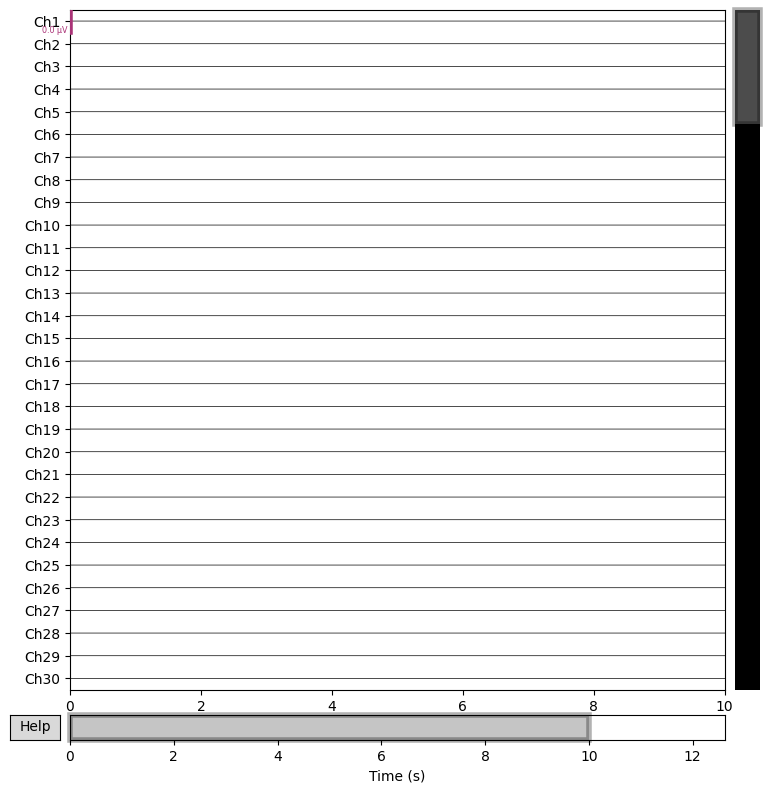

In [37]:
import mne

raw_file_path = "preprocessed_eeg_data-raw.fif"  # Update with your actual file path
raw = mne.io.read_raw_fif(raw_file_path, preload=True)
print(raw.info)
raw.plot(n_channels=30, scalings='auto', title='Preprocessed Raw EEG Data', show=True)

Reading /content/preprocessed_eeg_data-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-38-d36d33cc2e26>:3: RuntimeWarning: This filename (preprocessed_eeg_data-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file_path, preload=True)


<EpochsFIF | 6 events (all good), 0 – 2 s (baseline off), ~4.3 MB, data loaded,
 'Dummy Event': 6>


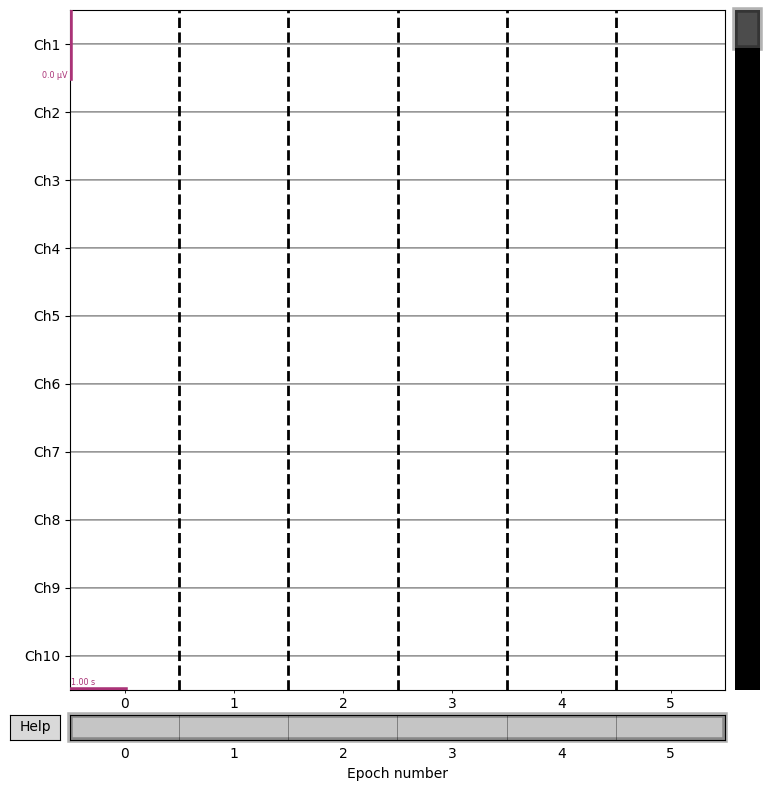

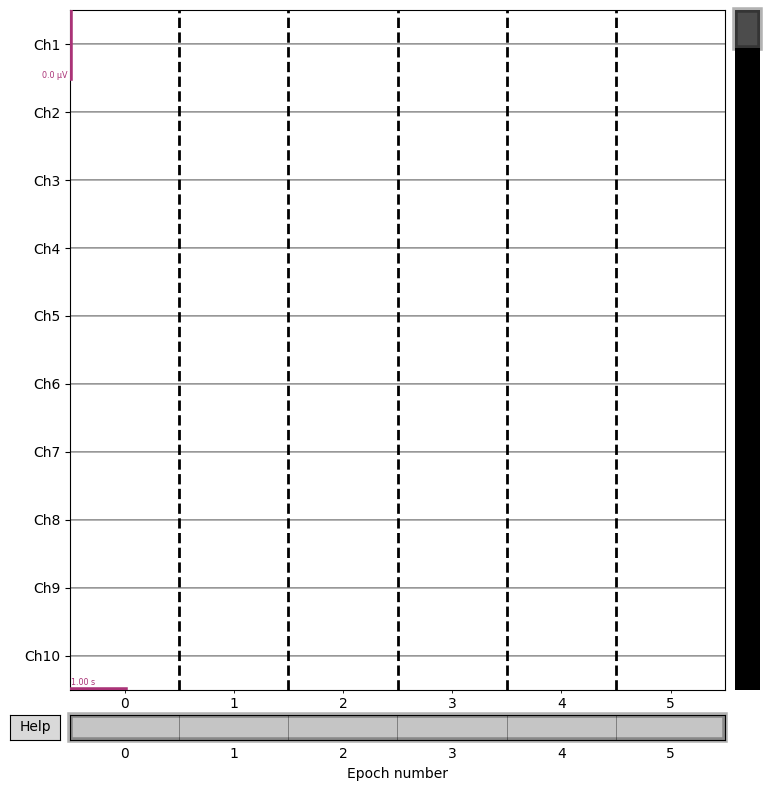

In [38]:
epochs_file_path = "preprocessed_eeg_data-epochs.fif"  # Update with your actual file path
epochs = mne.read_epochs(epochs_file_path, preload=True)
print(epochs)
epochs.plot(n_epochs=10, n_channels=10, scalings='auto', title='Preprocessed Epochs', show=True)